# Stock Market Prediction

## Overview

Accurate prediction of stock market asset is a significant and challenging task due to complicated nature of the financial stock markets. Considering the increasing availability and affordability of powerful computational engines, deep learning methods of prediction have proved its efficiency in finance.

## Business Understanding

A time series regression model using NN or other advanced techniques is built to predict the stock market. Stock market prediction aims to determine the future movement of the stock value of a financial exchange. This project is helpful for Stock investors and investment banks to have a better understanding in developing economical Strategy and in making financial decisions.

## Data Understanding

Data Collection by API

### Import Packages

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
import re
import pickle
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, auc, roc_curve
from sklearn.svm import SVC

from fbprophet import Prophet

import yfinance as yf

pd.options.display.max_columns = 200
sns.set_style('darkgrid')
#import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

### IEX API

https://iexcloud.io

In [2]:
#url ='https://cloud.iexapis.com/stable/stock/{}/chart/5y?token={}'.format(symbol, token)
url = 'https://cloud.iexapis.com/v1'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
          }

response = requests.get(url, params)
d = response.json()

In [3]:
d.keys()

dict_keys(['openapi', 'info', 'servers', 'components', 'paths'])

### Yahoo Finance

In [2]:
tick = yf.Ticker("aapl")

# get stock info
#tick.info

# get historical market data
df = tick.history(period="max")

In [3]:
#df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D')).fillna(method='bfill')
df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D')).interpolate()

In [4]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-03-28,121.216667,122.213336,120.126668,121.329999,85199100.0,0.0,0.0
2021-03-29,121.650002,122.580002,120.730003,121.389999,80819200.0,0.0,0.0
2021-03-30,120.110001,120.400002,118.860001,119.900002,85671900.0,0.0,0.0
2021-03-31,121.650002,123.519997,121.150002,122.150002,118323800.0,0.0,0.0
2021-04-01,123.660004,124.180000,122.489998,123.000000,74957400.0,0.0,0.0


## Data Preparation

### Exploratory Data Analysis

Text(0.5, 1.0, 'close')

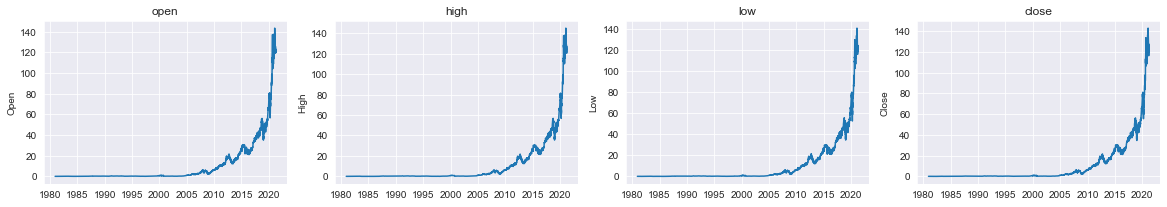

In [5]:
# plot target variables
fig, ax = plt.subplots(1, 4, figsize=(20,3))
sns.lineplot(data=df.Open, ax=ax[0])
ax[0].set_title('open')
sns.lineplot(data=df.High, ax=ax[1])
ax[1].set_title('high')
sns.lineplot(data=df.Low, ax=ax[2])
ax[2].set_title('low')
sns.lineplot(data=df.Close, ax=ax[3])
ax[3].set_title('close')
# plt.subplots_adjust(hspace = 0.5)
#plt.savefig('images/ohlc.jpeg', format='jpeg')

### Dickey-Fuller Test

In [6]:
def stationarity_check(TS):       
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)     
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()    
    # Plot rolling statistics:
    #fig = plt.figure(figsize=(12,6))
    orig = sns.lineplot(data=TS, palette=['blue'],label='Original')
    mean = sns.lineplot(data=roll_mean, palette=['red'], label='Rolling Mean')
    std = sns.lineplot(data=roll_std, palette=['black'], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])                   
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.Close)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

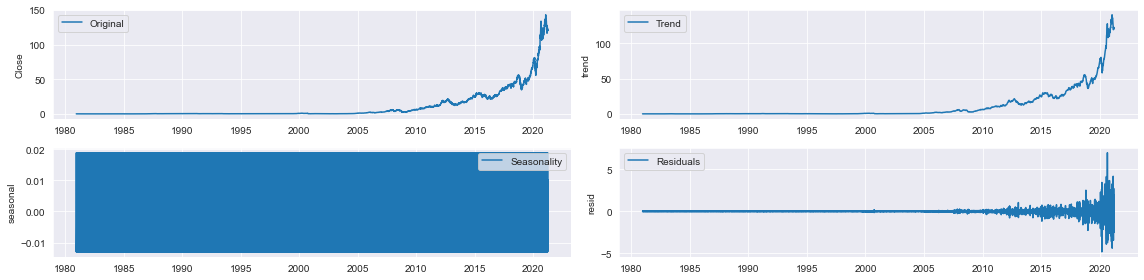

In [8]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.Close, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

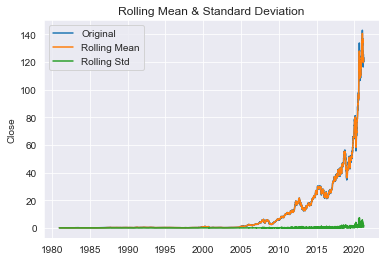

Results of Dickey-Fuller Test: 

Test Statistic                     4.328746
p-value                            1.000000
#Lags Used                        42.000000
Number of Observations Used    14676.000000
Critical Value (1%)               -3.430796
Critical Value (5%)               -2.861737
Critical Value (10%)              -2.566875
dtype: float64


In [9]:
stationarity_check(df.Close)

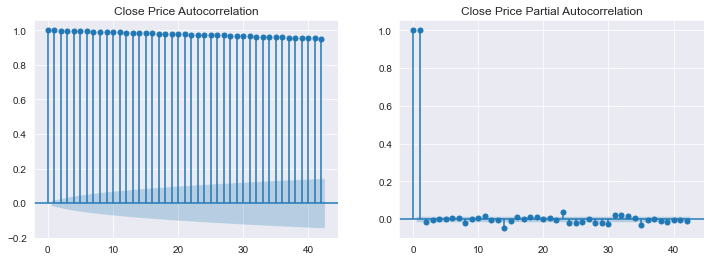

In [10]:
# Plot deaths ACF & PACF
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df['Close'], title='Close Price Autocorrelation', ax=ax[0]);
plot_pacf(df['Close'], title='Close Price Partial Autocorrelation', ax=ax[1]);
#plt.savefig('images/acf.jpeg', format='jpeg')

## Modeling

### SARIMAX

In [13]:
import statsmodels.api as sm

In [14]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

In [15]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.Close,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue

In [16]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 0)
pdqs    (1, 0, 1, 12)
aic             13378
Name: 37, dtype: object

In [17]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df.Close,
                                        exog=df.drop('Close', axis=1),
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 0, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Open,-0.5222,7.47e-06,-6.99e+04,0.000,-0.522,-0.522
High,0.8235,7.59e-06,1.08e+05,0.000,0.823,0.823
Low,0.6980,7.35e-06,9.5e+04,0.000,0.698,0.698
Volume,-1.911e-12,8.33e-12,-0.229,0.819,-1.82e-11,1.44e-11
Dividends,0.9550,1.96e-10,4.88e+09,0.000,0.955,0.955
Stock Splits,0.0006,3.05e-09,1.85e+05,0.000,0.001,0.001
ar.L1,-0.0659,3.83e-07,-1.72e+05,0.000,-0.066,-0.066
ma.L1,0.3055,3.36e-07,9.08e+05,0.000,0.306,0.306
ma.S.L12,-0.0307,4.32e-08,-7.11e+05,0.000,-0.031,-0.031
sigma2,0.0280,3.48e-05,804.344,0.000,0.028,0.028


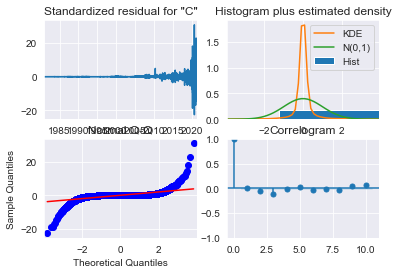

In [18]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics()
plt.show()

In [19]:
# Get predictions for training set and calculate confidence intervals
pred = output.get_prediction(start=df.index[-180], dynamic=False)
pred_conf = pred.conf_int()

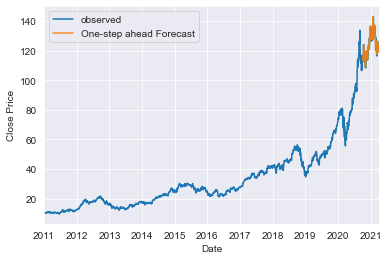

In [20]:
# Plot real vs predicted values along with confidence interval
# Plot observed values
ax = df.Close['2011':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
plt.legend()
#plt.savefig('images/SARIMAX.jpeg', format='jpeg')

In [22]:
# Get the real and predicted values
close_forecasted = pred.predicted_mean
close_truth = df.Close[-180:]

# Compute the mean square error
mse = ((close_forecasted - close_truth) ** 2).mean()
print('The RMSE of our forecasts is {}'.format(round(mse**.5, 2)))

The RMSE of our forecasts is 0.86


In [23]:
# calculate root mean squared error
sarimax_rmse = mean_squared_error(close_truth, close_forecasted, squared=False)
# calculate mean absolute error
sarimax_mape = mean_absolute_percentage_error(close_truth, close_forecasted)

print('The RMSE of our forecasts is {}'.format(round(sarimax_rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(sarimax_mape, 2)))

The RMSE of our forecasts is 0.86
The MAPE of our forecasts is 0.01


In [23]:
# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=180, exog=df.drop('Close', axis=1)[-180:])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

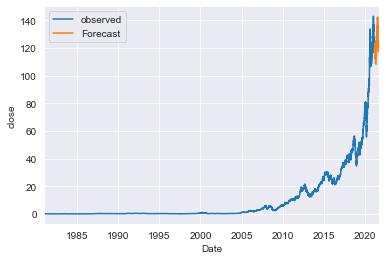

In [24]:
ax = df.Close.plot(label='observed')
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('close')

plt.legend()

## Facebook Prophet

In [240]:
# ts.index.name = 'ds'
# ts = ts.reset_index()
# ts = ts.rename(columns={'timeline': 'y'})

In [5]:
fb_close = pd.DataFrame()
fb_close['y'] = df.Close
fb_close.reset_index(inplace=True)
fb_close.rename(columns={'index': 'ds'}, inplace=True)

In [6]:
close_train_fb, close_test_fb = fb_close[:-180], fb_close[-180:]

In [7]:
model_close = Prophet(interval_width=0.95)
model_close.fit(close_train_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
future_dates = model_close.make_future_dataframe(periods=180, freq='D')
forecast_close = model_close.predict(future_dates)
forecast_close.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-12-12,0.079853,-10.254898,9.713907,0.079853,0.079853,-0.303184,-0.303184,-0.303184,-0.001832,-0.001832,-0.001832,-0.301352,-0.301352,-0.301352,0.0,0.0,0.0,-0.223331
1,1980-12-13,0.079907,-10.194224,9.541651,0.079907,0.079907,-0.307159,-0.307159,-0.307159,0.003086,0.003086,0.003086,-0.310246,-0.310246,-0.310246,0.0,0.0,0.0,-0.227252
2,1980-12-14,0.079962,-9.946484,9.028992,0.079962,0.079962,-0.335499,-0.335499,-0.335499,-0.015164,-0.015164,-0.015164,-0.320335,-0.320335,-0.320335,0.0,0.0,0.0,-0.255537
3,1980-12-15,0.080016,-9.817692,9.622332,0.080016,0.080016,-0.342231,-0.342231,-0.342231,-0.010810,-0.010810,-0.010810,-0.331421,-0.331421,-0.331421,0.0,0.0,0.0,-0.262214
4,1980-12-16,0.080071,-10.515354,10.420991,0.080071,0.080071,-0.342832,-0.342832,-0.342832,0.000433,0.000433,0.000433,-0.343265,-0.343265,-0.343265,0.0,0.0,0.0,-0.262761


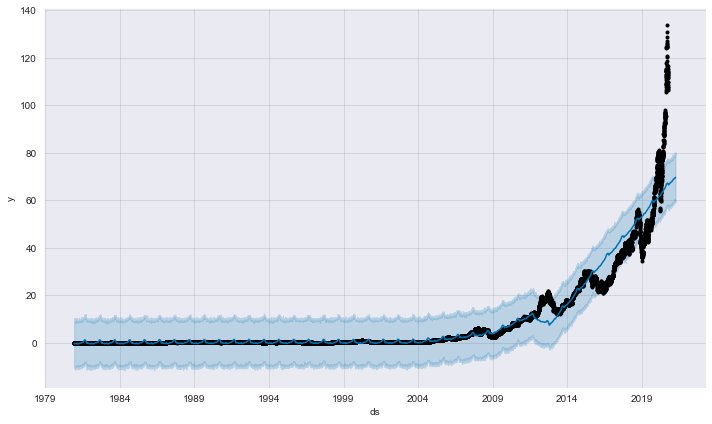

In [9]:
model_close.plot(forecast_close, uncertainty=True);
#plt.savefig('images/fbprophet.jpeg', format='jpeg')

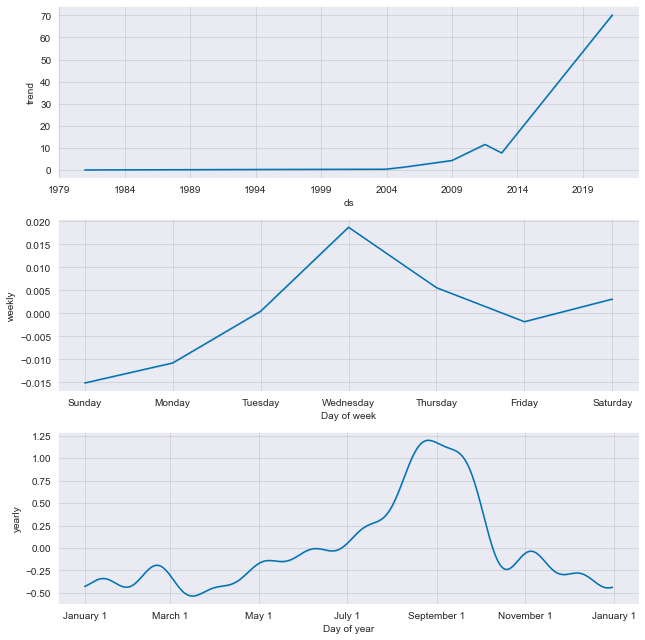

In [10]:
model_close.plot_components(forecast_close);

## LSTM (long short-term memory) Networks

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [26]:
def create_dataset(df, back=1):
    X, Y = [], []
    for i in range(len(df)-back-1):
        a = df[i:(i+back), 0]
        X.append(a)
        Y.append(dataset[i+back, 0])
    return np.array(X), np.array(Y)

In [105]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [107]:
time = 180
train, test = df_rnn[:-time], df_rnn[-time:]

look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [108]:
X_train = np.reshape(trainX, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [36]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [37]:
trainPredict = model.predict(X_train)
testPredict = model.predict(Y_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

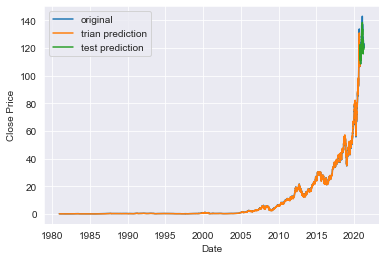

In [38]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots()
ax.plot(df_lstm.index, scaler.inverse_transform(dataset), label='original')
ax.plot(df_lstm.index, trainPredictPlot,label='trian prediction')
ax.plot(df_lstm.index, testPredictPlot,label='test prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
#plt.savefig('images/lstm.jpeg', format='jpeg')

## GRU (Gated Recurrent Unit)

In [109]:
gru_model = Sequential()
gru_model.add(GRU(4, input_shape=(1, look_back)))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [110]:
gru_trainPredict = gru_model.predict(trainX)
gru_testPredict = gru_model.predict(testX)

gru_trainPredict = scaler.inverse_transform(gru_trainPredict)
trainY = scaler.inverse_transform([trainY])
gru_testPredict = scaler.inverse_transform(gru_testPredict)
testY = scaler.inverse_transform([testY])

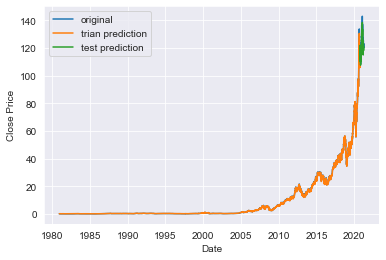

In [111]:
gru_trainPredictPlot = np.empty_like(dataset)
gru_trainPredictPlot[:, :] = np.nan
gru_trainPredictPlot[look_back:len(gru_trainPredict)+look_back, :] = gru_trainPredict
# shift test predictions for plotting
gru_testPredictPlot = np.empty_like(dataset)
gru_testPredictPlot[:, :] = np.nan
gru_testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = gru_testPredict
# plot baseline and predictions
fig, ax = plt.subplots()
ax.plot(df_lstm.index, scaler.inverse_transform(dataset), label='original')
ax.plot(df_lstm.index, gru_trainPredictPlot,label='trian prediction')
ax.plot(df_lstm.index, gru_testPredictPlot,label='test prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
#plt.savefig('images/gru.jpeg', format='jpeg')

## Evaluation

### metrics in SARIMAX

In [24]:
print('SARIMAX RMSE of close price: {}'.format(round(sarimax_rmse, 2)))
print('SARIMAX MAPE of close price: {}'.format(round(sarimax_mape, 2)))

SARIMAX RMSE of close price: 0.86
SARIMAX MAPE of close price: 0.01


### metrics in Facebook Prophet

In [12]:
# calculate root mean squared error
train_rmse_close_fb = mean_squared_error(close_train_fb['y'], forecast_close['yhat'][:-180], squared=False)
test_rmse_close_fb = mean_squared_error(close_test_fb['y'], forecast_close['yhat'][-180:], squared=False)
print('Facebook Prophet close price train RMSE: {:.2f}'.format(train_rmse_close_fb))
print('Facebook Prophet close price test RMSE: {:.2f}'.format(test_rmse_close_fb))
# calculate mean absolute error
train_mape_close_fb = mean_absolute_percentage_error(close_train_fb['y'], forecast_close['yhat'][:-180])
test_mape_close_fb = mean_absolute_percentage_error(close_test_fb['y'], forecast_close['yhat'][-180:])
print('Facebook Prophet close price train MAPE: {:.2f}'.format(train_mape_close_fb))
print('Facebook Prophet close price test MAPE: {:.2f}'.format(test_mape_close_fb))

Facebook Prophet close price train RMSE: 5.02
Facebook Prophet close price test RMSE: 56.71
Facebook Prophet close price train MAPE: 1.38
Facebook Prophet close price test MAPE: 0.45


### metrics in LSTM Networks

In [39]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks close price train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks close price test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
print('LSTM Networks close price train MAPE: {:.2f}'.format(trainScore_mape))
print('LSTM Networks close price test MAPE: {:.2f}'.format(testScore_mape))

LSTM Networks close price train RMSE: 0.37
LSTM Networks close price test RMSE: 2.65
LSTM Networks close price train MAPE: 0.15
LSTM Networks close price test MAPE: 0.02


### metrics in GRU Networks

In [112]:
# calculate root mean squared error
gru_trainScore = mean_squared_error(trainY[0], gru_trainPredict[:,0], squared=False)
gru_testScore = mean_squared_error(testY[0], gru_testPredict[:,0], squared=False)
print('GRU Networks close price train RMSE: {:.2f}'.format(gru_trainScore))
print('GRU Networks close price test RMSE: {:.2f}'.format(gru_testScore))
# calculate mean absolute error
gru_trainScore_mape = mean_absolute_percentage_error(trainY[0], gru_trainPredict[:,0])
gru_testScore_mape = mean_absolute_percentage_error(testY[0], gru_testPredict[:,0])
print('GRU Networks close price train MAPE: {:.2f}'.format(gru_trainScore_mape))
print('GRU Networks close price test MAPE: {:.2f}'.format(gru_testScore_mape))

GRU Networks close price train RMSE: 0.36
GRU Networks close price test RMSE: 2.99
GRU Networks close price train MAPE: 0.26
GRU Networks close price test MAPE: 0.02
